In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.optimize import fmin_l_bfgs_b
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [15, 5]

In [3]:
data, target = load_boston(return_X_y=True)
data = normalize(data)
data = np.concatenate((data, np.ones(shape=(data.shape[0], 1))), axis=1)
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

### Implement from Python scratch

#### Hypothesis

$$h(\theta) = X\theta^{T}$$


#### Optimization objective

$$ J(\theta) =  \dfrac{1}{2m}\sum_{i=1}^{m}\left(h_\theta\left(x^{(i)}\right)-y^{(i)}\right)^2$$


#### Update parameters

$$ \theta_{j} := \theta_{j} - \alpha\dfrac{\partial}{\partial\theta_j}J(\theta) = \theta_{j}-\alpha\dfrac{1}{m}\sum_{i=1}^{m}\left(h_{\theta}(x^{(i)}) - y^{(i)}\right)x_{j}^{(i)}$$

In [4]:
def grads(f, x0, args=(), e=1e-5):
    gs = []
    for i in range(len(x0)):
        x = list(x0)
        x[i] += e
        g = (f(x, *args) - f(x0, *args)) / e
        gs.append(g)
    return gs

In [5]:
def gradient_descent(f, x0, args=(), alpha=0.1, maxiter=10000, tol=1e-3, full_return=False):
    J_his = []
    x_his = []
    for i in range(maxiter):
        J = f(x0, *args)
        J_his.append(J)
        x_his.append(x0)
        if J < tol:
            break
        g = grads(f, x0, args)
        x0 = [x0[i] - alpha*g[i] for i in range(len(x0))]
    if full_return:
        return x0, J_his, x_his
    else:
        return x0

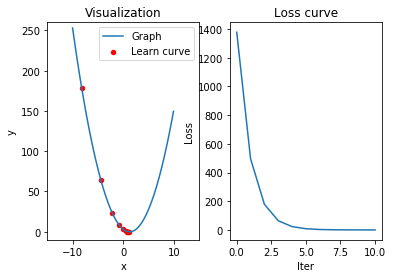

In [6]:
def f(x):
    return 2*x[0]**2 - 5*x[0] + 3

x = [i/10 for i in range(-100,100)]
y = [f([x_i]) for x_i in x]
x0, J_his, x_his = gradient_descent(f, x0=[-25], full_return=True)

plt.subplot(121)
plt.title('Visualization')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_his, J_his, label='Learn curve', c='red', s=20)
plt.plot(x, y, label='Graph')
plt.axis([-15,15,-10,260])
plt.legend()
plt.subplot(122)
plt.title('Loss curve')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.plot(list(range(len(J_his))), J_his)
plt.show()

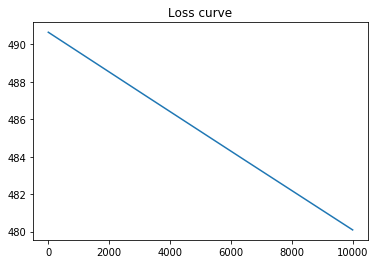

In [7]:
def loss_func(theta, X, y):
    return ((X.dot(theta).reshape(-1)-y)**2).mean()
theta = np.random.rand(x_train.shape[1], 1)
x0, J_his, x_his = gradient_descent(loss_func, x0=theta, args=(x_train, y_train), alpha=100, full_return=True)

plt.title('Loss curve')
plt.plot(list(range(len(J_his))), J_his)
plt.show()

### Implement from scipy

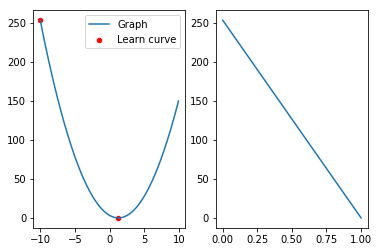

In [8]:
x_his = []
y_his = []

def f(x):
    return 2*x[0]**2 - 5*x[0] + 3

def callback(xk):
    x_his.append(xk[0])
    y_his.append(f(xk))

x = [i/10 for i in range(-100,100)]
y = [f([x_i]) for x_i in x]
x_best = fmin_l_bfgs_b(f, x0=[-15], approx_grad=True, callback=callback)[0]

plt.subplot(121)
plt.scatter(x_his, y_his, label='Learn curve', c='red', s=20)
plt.plot(x, y, label='Graph')
# plt.axis([-15,15,-1000,1000])
plt.legend()
plt.subplot(122)
plt.plot(list(range(len(y_his))), y_his)
plt.show()

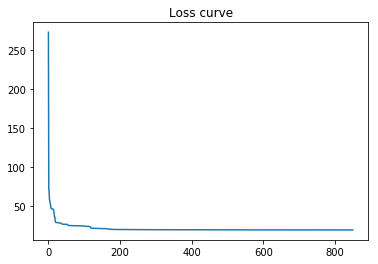

In [9]:
x_his = []
y_his = []
def loss_func(theta, X, y):
    return ((X.dot(theta).reshape(-1)-y)**2).mean()

def callback(xk):
    x_his.append(xk)
    y_his.append(loss_func(xk, x_train, y_train))
    
theta = np.random.rand(x_train.shape[1], 1)
x0 = fmin_l_bfgs_b(loss_func, x0=theta, args=(x_train, y_train), callback=callback, approx_grad=True)[0]

plt.title('Loss curve')
plt.plot(list(range(len(y_his))), y_his)
plt.show()

### Implement from Scikit-learn

In [10]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('MSE = {}\nMAE = {}'.format(mse, mae))

MSE = 33.58953891413901
MAE = 3.8587708798765608


### Implement from Tensorflow

In [45]:
tf.reset_default_graph()
with tf.name_scope('Input'):
    x = tf.placeholder(shape=(None, 14), dtype=tf.float32, name='X')
    y = tf.placeholder(shape=(None, 1), dtype=tf.float32, name='y')
with tf.name_scope('Parameters'):
    theta = tf.Variable(np.random.rand(14,1), dtype=tf.float32, name='Theta')
with tf.name_scope('Initial'):
    init_ops = tf.global_variables_initializer()
with tf.name_scope('Hypothesis'):
    y_pred = tf.matmul(x, theta)
with tf.name_scope('Optimizer'):
    loss = tf.reduce_mean(tf.squared_difference(y_pred, y))
    optimizer_ops = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
writer = tf.summary.FileWriter(graph=tf.get_default_graph(), logdir='logs')
train_summary = tf.summary.scalar('train_error', loss)
validation_summary = tf.summary.scalar('validation_error', loss)
with tf.Session() as sess:
    sess.run(init_ops)
    for i in range(10000):
        sess.run(optimizer_ops, feed_dict={x:x_train, y:y_train.reshape(-1,1)})
        train_loss, train_sum = sess.run([loss, train_summary], feed_dict={x:x_train, y:y_train.reshape(-1,1)})
        writer.add_summary(train_sum, i)
        val_loss, val_sum = sess.run([loss, validation_summary], feed_dict={x:x_test, y:y_test.reshape(-1,1)})
        writer.add_summary(val_sum, i)